<a href="https://colab.research.google.com/github/bkrant/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

Pandas operations

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

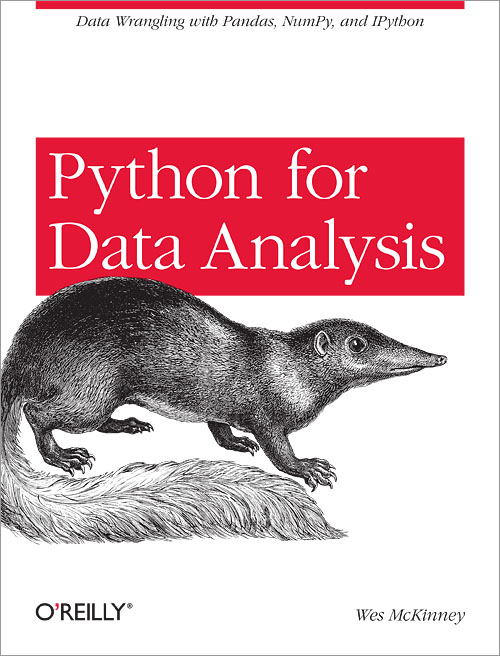

In [50]:
import numpy as np
import pandas as pd
from IPython.core.display import Image
Image('http://akamaicovers.oreilly.com/images/0636920023784/lrg.jpg')

##Plotting a histogram

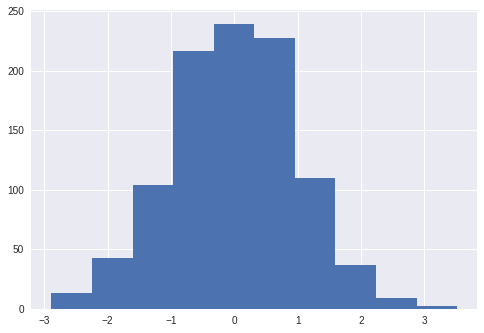

In [7]:
import matplotlib.pyplot as plt
# Generate some random data
data = np.random.randn(1000)

ax = plt.hist(data)

#Computing histograms as matrices
The function histogram() in the numpy module will count frequencies into bins and return the result as a 2-dimensional array.

In [8]:
np.histogram(data)

(array([ 13,  43, 104, 216, 239, 227, 110,  37,   9,   2]),
 array([-2.88601109, -2.24574763, -1.60548416, -0.9652207 , -0.32495724,
         0.31530623,  0.95556969,  1.59583315,  2.23609662,  2.87636008,
         3.51662355]))

#Filtering data

In [21]:
list(filter(lambda x: x > 0, [-5, 2, 3, -10, 0, 1]))

[2, 3, 1]

In [33]:
list(filter(lambda y: y != ' ', 'hello world'))

['h', 'e', 'l', 'l', 'o', 'w', 'o', 'r', 'l', 'd']

In [39]:
list(map(ord, 'hello world'))

[104, 101, 108, 108, 111, 32, 119, 111, 114, 108, 100]

#Reading Text Files
To read an entire text file as a list of lines use the readlines() method of a file object.

In [0]:
f = open('/etc/group')
result = f.readlines()
f.close()

In [48]:
# Print the first line
result[0]

'root:x:0:\n'

In [49]:
''.join(result)

'root:x:0:\ndaemon:x:1:\nbin:x:2:\nsys:x:3:\nadm:x:4:\ntty:x:5:\ndisk:x:6:\nlp:x:7:\nmail:x:8:\nnews:x:9:\nuucp:x:10:\nman:x:12:\nproxy:x:13:\nkmem:x:15:\ndialout:x:20:\nfax:x:21:\nvoice:x:22:\ncdrom:x:24:\nfloppy:x:25:\ntape:x:26:\nsudo:x:27:\naudio:x:29:\ndip:x:30:\nwww-data:x:33:\nbackup:x:34:\noperator:x:37:\nlist:x:38:\nirc:x:39:\nsrc:x:40:\ngnats:x:41:\nshadow:x:42:\nutmp:x:43:\nvideo:x:44:\nsasl:x:45:\nplugdev:x:46:\nstaff:x:50:\ngames:x:60:\nusers:x:100:\nnogroup:x:65534:\nssh:x:101:\nsystemd-journal:x:102:\nsystemd-network:x:103:\nsystemd-resolve:x:104:\ninput:x:105:\nnvidia-persistenced:x:106:\nmessagebus:x:107:\nrdma:x:108:\n'

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

2.  What was the most challenging part of what you did?

3.  What was the most interesting thing you learned?

4.  What area would you like to explore with more time?




Looked at different online Jupyter notebooks to scan for interesting and potentially useful code. The first block of code shows how to display an image from the internet in the notebook. This may be useful to make the notebook user friendly. The second block of code shows how to create a histogram and count the number of elements in each bin and the bins themselves. Used the filter and map functions to apply a function to each element in a list - this is useful for EDA. The most challenging part was understanding how to read files because because the output of the readlines() is not intuitive. The most interesting part is the map() and filter() because I can see myself using them for data science. I would like to explore how to make cool plots/graphs.

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.